## Importing the files and doing bare minimum addn'l prep to them

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
X_train = pd.read_csv('../../data/X_train',index_col= 0)
y_train = pd.read_csv('../../data/y_train', index_col =0)
X_test = pd.read_csv('../../data/X_test', index_col = 0)
y_test = pd.read_csv('../../data/y_test', index_col = 0)

In [37]:
def remove_unsure(score):
    if score == 3:
        return 1
    else: 
        return score

In [38]:
y_test['emotion'] = y_test['emotion'].apply(lambda x: remove_unsure(x))

In [39]:
y_train['emotion'] = y_train['emotion'].apply(lambda x: remove_unsure(x))

In [40]:
X_train[X_train.isna().any(axis=1)]


,cleaned_tweets
6,NaN
7346,NaN


In [41]:
y_train = y_train.drop(index=[6,7346])


In [42]:
X_train.dropna(inplace= True)

In [43]:
X_train.isna().sum()

cleaned_tweets    0
dtype: int64

In [44]:
X_train.shape, y_train.shape

((6363, 1), (6363, 1))

In [45]:
X_test.isna().sum()

cleaned_tweets    0
dtype: int64

In [46]:
X_test.shape, y_test.shape

((7274, 1), (7274, 1))

### Vectorize DFs


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [48]:
tfidf_vec = TfidfVectorizer()

In [49]:
X_tr_tfidf = tfidf_vec.fit_transform(X_train['cleaned_tweets'])
X_te_tfidf = tfidf_vec.transform(X_test['cleaned_tweets'])

In [50]:

X_tr_tfidf_df = pd.DataFrame(X_tr_tfidf.toarray(), 
                              columns=tfidf_vec.get_feature_names(), 
                              index=X_train.index)

In [51]:
X_te_tfidf_df = pd.DataFrame(X_te_tfidf.toarray(),
                            columns = tfidf_vec.get_feature_names(),
                            index= X_test.index)

## Dimensionality Reduction 

Dimensionality reduction using truncated SVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. **This means it can work with sparse matrices efficiently.**

**In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).**

n_componentsint, default=2
Desired dimensionality of output data. Must be strictly less than the number of features. **The default value is useful for visualisation. For LSA, a value of 100 is recommended.**

In [52]:
from sklearn.decomposition import TruncatedSVD

In [65]:
svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)
svd.fit(X_tr_tfidf_df)
X_tr_tfidf_SVD = svd.transform(X_tr_tfidf_df)

In [66]:
X_tr_tfidf_SVD.shape

(6363, 100)

In [67]:
X_te_tfidf_SVD = svd.transform(X_te_tfidf_df)

In [68]:
from sklearn.cluster import KMeans

In [69]:
k_means = KMeans(n_clusters=3).fit(X_tr_tfidf_SVD)

predicted_clusters = k_means.labels_

In [70]:
predicted_clusters

array([0, 0, 0, ..., 0, 2, 0])

In [71]:
centers = k_means.cluster_centers_

In [72]:
type(X_tr_tfidf_SVD)

numpy.ndarray

In [73]:
y_train

,emotion
2954,1
2709,2
2357,2
6195,2
1366,2
...,...
5734,1
5191,2
5390,2
860,2


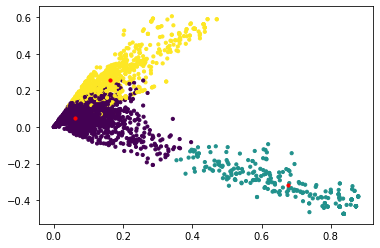

In [74]:
plt.scatter(X_tr_tfidf_SVD[:, 0], X_tr_tfidf_SVD[:, 1], c=predicted_clusters, s=10)
plt.scatter(centers[:, 0], centers[:, 1], c='r', s=10)

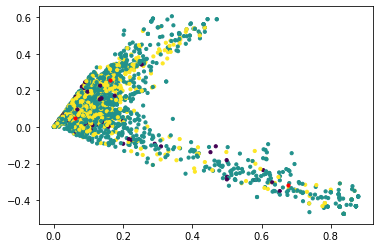

In [75]:
plt.scatter(X_tr_tfidf_SVD[:, 0], X_tr_tfidf_SVD[:, 1], c=y_train['emotion'], s=10)
plt.scatter(centers[:, 0], centers[:, 1], c='r', s=10)

# Scores

In [82]:
from sklearn.metrics import calinski_harabasz_score

In [93]:
k_means_2 = KMeans(n_clusters=2).fit(X_tr_tfidf_SVD)
k_means_3 = KMeans(n_clusters=3).fit(X_tr_tfidf_SVD)
k_means_4 = KMeans(n_clusters=10).fit(X_tr_tfidf_SVD)
k_means_5 = KMeans(n_clusters=25).fit(X_tr_tfidf_SVD)
k_means_6 = KMeans(n_clusters=50).fit(X_tr_tfidf_SVD)
k_means_7 = KMeans(n_clusters=60).fit(X_tr_tfidf_SVD)


k_list = [k_means_2, k_means_3,k_means_4,k_means_5,k_means_6, k_means_7]

In [94]:
CH_score = [calinski_harabasz_score(X_tr_tfidf_SVD,k.labels_) for k in k_list]

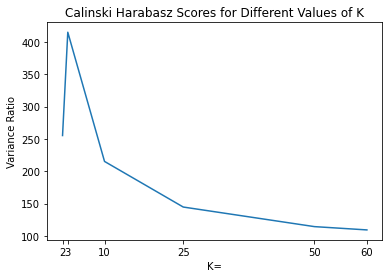

In [96]:
plt.plot([2,3, 10, 25, 50, 60], CH_score)
plt.xticks([2,3, 10, 25, 50, 60])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

In [98]:
wcss_score = []

In [99]:
wcss_score = [k.inertia_ for k in k_list]

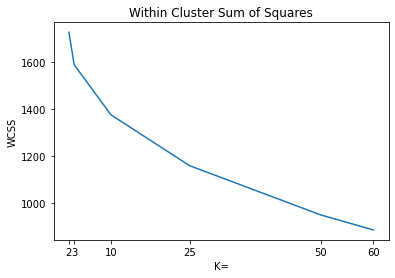

In [101]:
plt.plot([2,3, 10, 25, 50, 60], wcss_score)
plt.xticks([2,3, 10, 25, 50, 60])

plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

In [103]:
from sklearn.metrics import silhouette_score

In [104]:
# Generate silhouette coefficient for each k
X = X_tr_tfidf_SVD
silhouette_plot = []
for k in [2,3, 10, 25, 50, 60]:
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

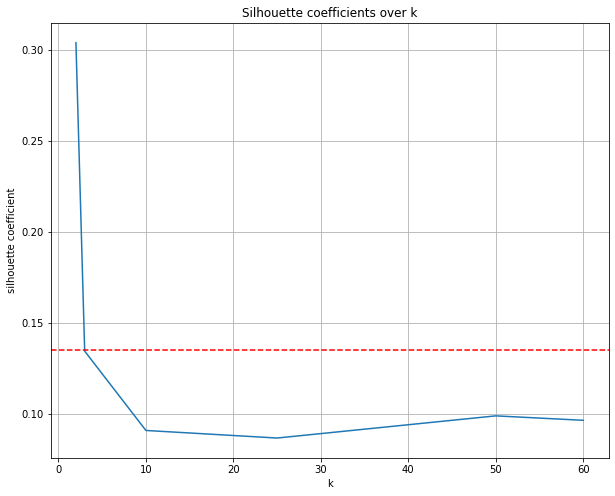

In [106]:
# Plot Silhouette coefficient
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Silhouette coefficients over k')
ax.set_xlabel('k')
ax.set_ylabel('silhouette coefficient')
ax.plot([2,3, 10, 25, 50, 60], silhouette_plot)
ax.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
ax.grid(True)